# 01 — Data Exploration

This notebook provides an initial look at the **Inside Airbnb** dataset for **Austin, TX**.
We examine data structure, quality, and basic distributions before deeper analysis.

**Objectives:**
- Understand the shape and types of each dataset
- Assess data quality (missing values, outliers)
- Get initial sense of price, location, and property distributions

## Setup

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_listings, load_calendar, load_reviews, load_geojson

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

%matplotlib inline

## 1. Listings Dataset

In [2]:
listings = load_listings('../data/sample/listings_sample.csv')
print(f'Shape: {listings.shape[0]:,} rows × {listings.shape[1]} columns')
listings.head(3)

Shape: 223 rows × 44 columns


,id,listing_url,name,description,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,bathrooms_text,price,minimum_nights,maximum_nights,instant_bookable,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,amenities
0,57187,https://www.airbnb.com/rooms/57187,"An Austin ""Weird"" Home in Peaceful Zilker Park",Less than one mile to Zilker Park ---stay near...,272156,Lois,2010-10-27,"Austin, TX",within an hour,100%,99%,t,1.00,78704,30.26,-97.77,Entire guesthouse,Entire home/apt,6,1.00,3.00,1 bath,$150.00,1,365,t,8,38,68,335,1090,26,0,2011-01-02,2025-08-16,4.91,4.94,4.93,4.96,4.97,4.95,4.82,6.09,"[""Private patio or balcony"", ""AC - split type ..."
1,202187,https://www.airbnb.com/rooms/202187,South Congress Apartment,NaN,989596,John,2011-08-18,"Austin, TX",within an hour,100%,100%,t,2.00,78704,30.25,-97.75,Entire guesthouse,Entire home/apt,2,1.00,2.00,1 bath,$72.00,1,21,t,6,9,20,210,1133,81,2,2011-09-26,2025-09-02,4.88,4.93,4.83,4.96,4.92,4.98,4.90,6.66,"[""Coffee"", ""Wine glasses"", ""Iron"", ""Single lev..."
2,240541,https://www.airbnb.com/rooms/240541,Stay in the Birdhouse! East/Downtow,Small private studio in the backyard of an eas...,1246229,Elizabeth,2011-10-04,"Austin, TX",within an hour,100%,98%,f,3.00,78702,30.25,-97.73,Entire guesthouse,Entire home/apt,2,1.00,1.00,1 bath,$45.00,1,15,f,13,23,23,107,948,77,3,2012-02-21,2025-09-02,4.64,4.74,4.62,4.85,4.88,4.85,4.71,5.74,"[""Private patio or balcony"", ""Iron"", ""Hot wate..."


In [3]:
listings.dtypes

id                               int64
listing_url                        str
name                               str
description                        str
host_id                          int64
host_name                          str
host_since                         str
host_location                      str
host_response_time                 str
host_response_rate                 str
host_acceptance_rate               str
host_is_superhost                  str
host_listings_count            float64
neighbourhood_cleansed           int64
latitude                       float64
longitude                      float64
property_type                      str
room_type                          str
accommodates                     int64
bedrooms                       float64
beds                           float64
bathrooms_text                     str
price                              str
minimum_nights                   int64
maximum_nights                   int64
instant_bookable         

### Missing Values

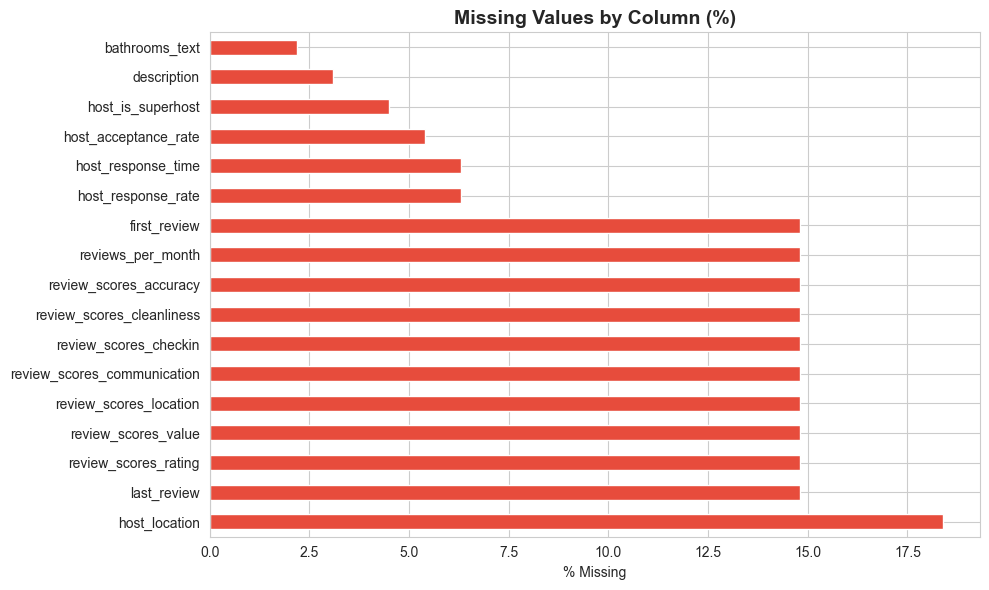


Columns with >50% missing: []


In [4]:
missing = listings.isnull().sum()
missing_pct = (missing / len(listings) * 100).round(1)
missing_df = pd.DataFrame({'missing': missing, 'pct': missing_pct})
missing_df = missing_df[missing_df['missing'] > 0].sort_values('pct', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
missing_df['pct'].plot(kind='barh', color='#e74c3c', ax=ax)
ax.set_title('Missing Values by Column (%)', fontweight='bold', fontsize=14)
ax.set_xlabel('% Missing')
plt.tight_layout()
plt.show()

print(f'\nColumns with >50% missing: {list(missing_df[missing_df.pct > 50].index)}')

### Raw Price Distribution

Before cleaning, let's see what the price column looks like. Inside Airbnb stores prices as strings with `$` signs.

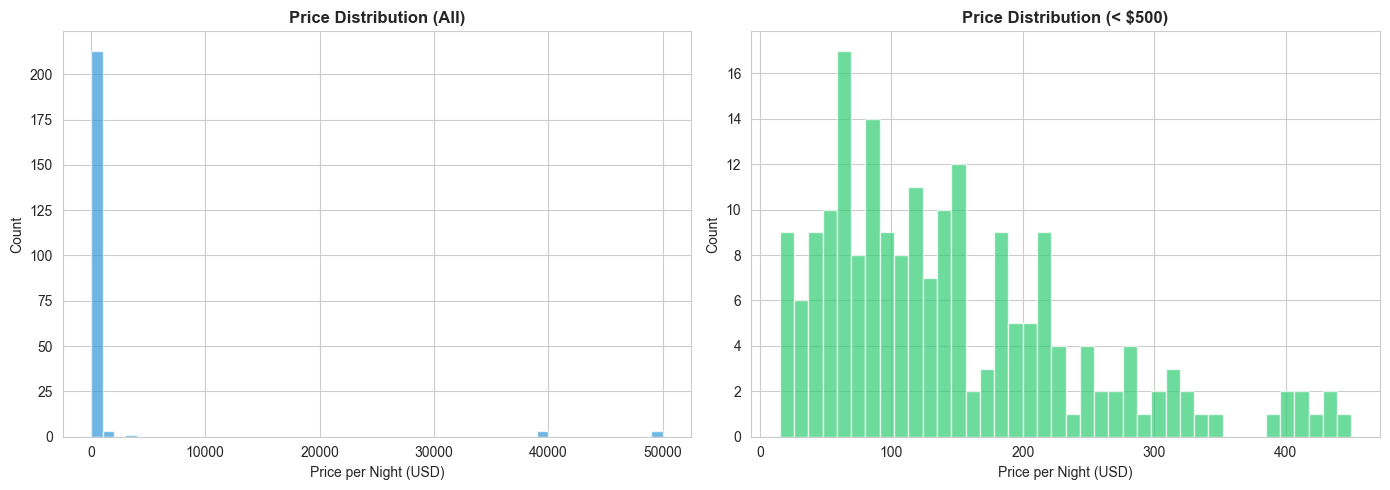

count     223.00
mean     1417.66
std      7316.15
min        15.00
25%        72.50
50%       140.00
75%       231.50
max     50000.00
Name: price_num, dtype: float64


In [5]:
listings['price_num'] = listings['price'].apply(
    lambda x: float(str(x).replace('$', '').replace(',', '')) if pd.notna(x) else np.nan
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
axes[0].hist(listings['price_num'].dropna(), bins=50, color='#3498db', alpha=0.7, edgecolor='white')
axes[0].set_title('Price Distribution (All)', fontweight='bold')
axes[0].set_xlabel('Price per Night (USD)')
axes[0].set_ylabel('Count')

# Filtered to <$500 for detail
filtered = listings['price_num'][listings['price_num'] < 500]
axes[1].hist(filtered.dropna(), bins=40, color='#2ecc71', alpha=0.7, edgecolor='white')
axes[1].set_title('Price Distribution (< $500)', fontweight='bold')
axes[1].set_xlabel('Price per Night (USD)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(listings['price_num'].describe())

### Room Type & Property Type

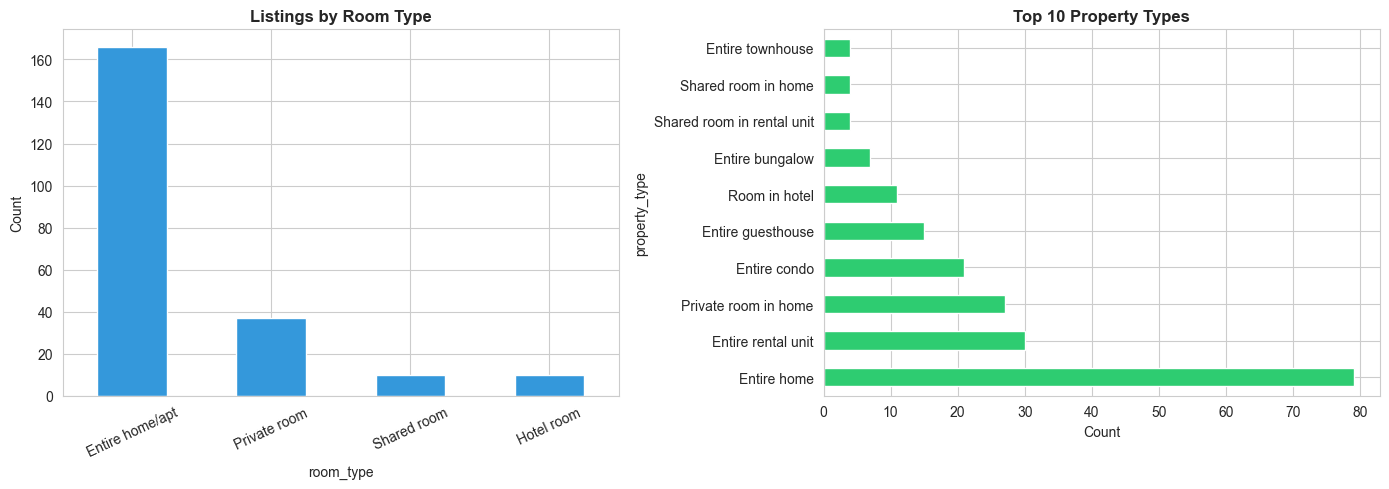

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

listings['room_type'].value_counts().plot(kind='bar', ax=axes[0], color='#3498db', edgecolor='white')
axes[0].set_title('Listings by Room Type', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=25)

listings['property_type'].value_counts().head(10).plot(kind='barh', ax=axes[1], color='#2ecc71', edgecolor='white')
axes[1].set_title('Top 10 Property Types', fontweight='bold')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

### Geographic Coverage

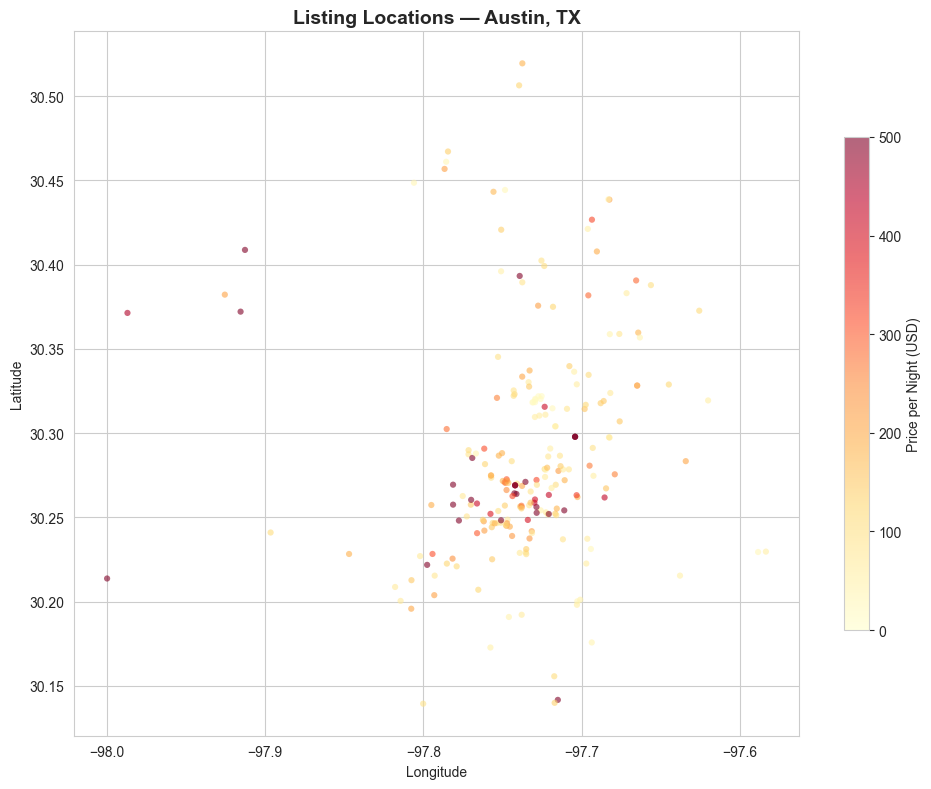

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    listings['longitude'], listings['latitude'],
    c=listings['price_num'], cmap='YlOrRd', alpha=0.6, s=20,
    vmin=0, vmax=500, edgecolors='none'
)
plt.colorbar(scatter, label='Price per Night (USD)', shrink=0.7)
ax.set_title('Listing Locations — Austin, TX', fontweight='bold', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## 2. Calendar Dataset

In [8]:
calendar = load_calendar('../data/sample/calendar_sample.csv')
print(f'Shape: {calendar.shape[0]:,} rows × {calendar.shape[1]} columns')
print(f'Date range: {calendar.date.min()} to {calendar.date.max()}')
calendar.head()

Shape: 3,650 rows × 6 columns
Date range: 2025-09-16 00:00:00 to 2026-09-16 00:00:00


,listing_id,date,available,price,minimum_nights,maximum_nights
0,57187,2025-09-17,t,$153.73,1,365
1,57187,2025-09-18,f,$148.96,1,365
2,57187,2025-09-19,f,$170.34,2,365
3,57187,2025-09-20,f,$185.64,2,365
4,57187,2025-09-21,f,$155.66,1,365


In [9]:
avail_counts = calendar['available'].value_counts()
print(f'Available: {avail_counts.get("t", 0):,} ({avail_counts.get("t", 0)/len(calendar)*100:.1f}%)')
print(f'Booked:    {avail_counts.get("f", 0):,} ({avail_counts.get("f", 0)/len(calendar)*100:.1f}%)')

Available: 2,217 (60.7%)
Booked:    1,433 (39.3%)


## 3. Reviews Dataset

In [10]:
reviews = load_reviews('../data/sample/reviews_sample.csv')
print(f'Shape: {reviews.shape[0]:,} rows × {reviews.shape[1]} columns')
print(f'Date range: {reviews.date.min()} to {reviews.date.max()}')
reviews.head(3)

Shape: 500 rows × 6 columns
Date range: 2011-09-26 00:00:00 to 2025-09-07 00:00:00


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,48867583,412950002433755528,2021-07-23,4286514,Brett,"Very nice place – great bar, workout room, and..."
1,5873238,1303083576906699593,2024-12-02,339252274,Axton,quiet quaint cute
2,21148947,1277682205808252403,2024-10-28,590287279,Dylan,The place was not cleaned before our arrival. ...


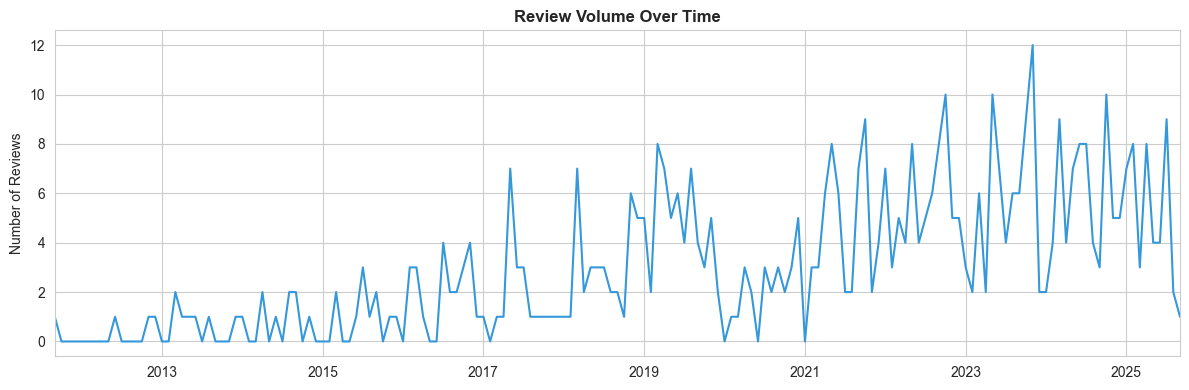

In [11]:
reviews_monthly = reviews.set_index('date').resample('ME').size()
fig, ax = plt.subplots(figsize=(12, 4))
reviews_monthly.plot(ax=ax, color='#3498db', linewidth=1.5)
ax.set_title('Review Volume Over Time', fontweight='bold')
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 4. Neighborhoods GeoJSON

Neighborhoods: 44


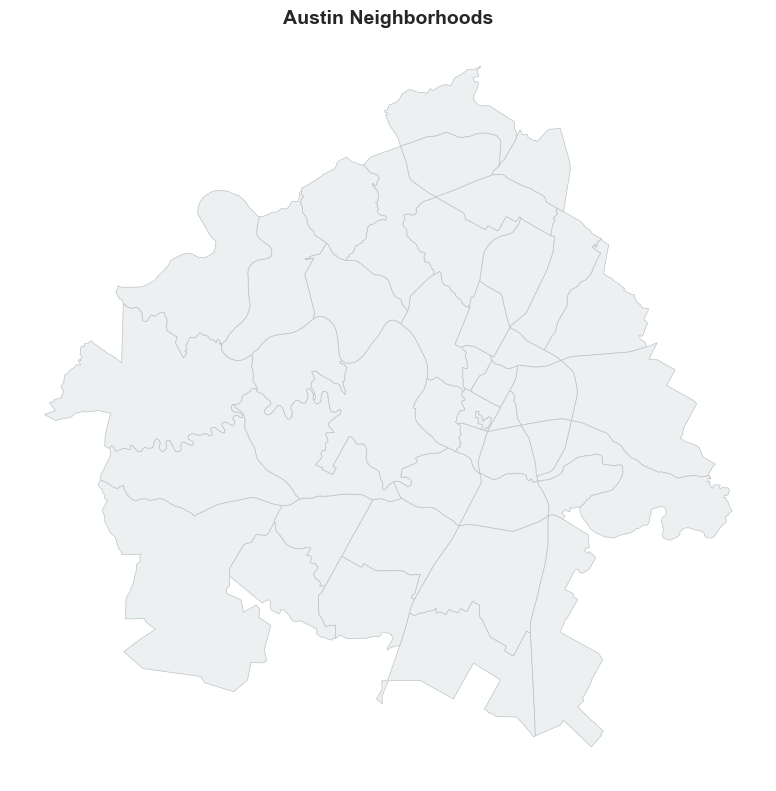

In [12]:
geo = load_geojson('../data/sample/neighbourhoods.geojson')
print(f'Neighborhoods: {len(geo)}')

fig, ax = plt.subplots(figsize=(8, 8))
geo.plot(ax=ax, color='#ecf0f1', edgecolor='#bdc3c7', linewidth=0.5)
ax.set_title('Austin Neighborhoods', fontweight='bold', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Key Findings

1. **Dataset size:** The sample contains 200+ listings with 44 attributes each — the full Austin dataset has 10,000+ listings
2. **Price range:** Listings span from budget ($15/night) to premium ($1,000+/night)
3. **Room types:** Dominated by entire homes/apartments, with some private rooms
4. **Missing data:** Some review scores and host response fields have notable gaps — will be handled in cleaning
5. **Geographic spread:** Listings concentrate in central Austin with clusters around downtown, East Austin, and South Congress

**Next:** [02 — Market Overview](02_market_overview.ipynb) for cleaned data analysis and market metrics.